In [57]:
# https://www.youtube.com/watch?v=zxD-v3ve-bk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import splitfolders
import os

In [58]:
splitfolders.ratio(
    "data", output="data_split", seed=42, ratio=(0.8, 0.1, 0.1)
)  # default values

In [59]:
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
    ]
)

In [60]:
train_data = datasets.ImageFolder(
    root=os.path.join("data_split", "train"), transform=transform
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)

val_data = datasets.ImageFolder(
    root=os.path.join("data_split", "val"), transform=transform
)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=True)

In [61]:
print(train_data)

Dataset ImageFolder
    Number of datapoints: 202
    Root location: data_split/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


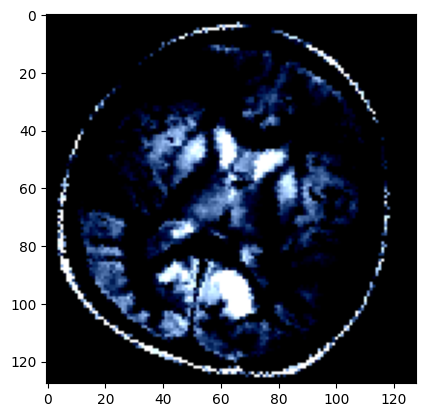

In [62]:
img, label = train_data[100]
plt.imshow(img.permute(1, 2, 0))

In [63]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.leaky_relu = nn.LeakyReLU()
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.pool1(self.leaky_relu(self.conv1(x)))
        x = self.pool2(self.leaky_relu(self.conv2(x)))
        x = self.pool3(self.leaky_relu(self.conv3(x)))
        x = self.pool4(self.leaky_relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [64]:
writer = SummaryWriter("logs")

In [65]:
num_epochs = 30
model = CNNModel(num_classes=len(train_data.classes))
error = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

In [66]:
train_loss_list = []
val_loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        writer.add_scalar("Loss/Train", loss.item(), epoch * len(train_loader) + i)

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)

    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = error(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_running_loss / len(val_loader)
    val_loss_list.append(val_loss)
    writer.add_scalar("Validation/Train", val_loss, epoch)
    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)
    writer.add_scalar("Accuracy/Train", accuracy, epoch)

    scheduler.step(val_loss)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%"
    )

print("Finished Training")
writer.close()

Epoch [1/30], Train Loss: 0.7035, Val Loss: 0.6732, Accuracy: 62.50%
Epoch [2/30], Train Loss: 0.6607, Val Loss: 0.6378, Accuracy: 62.50%
Epoch [3/30], Train Loss: 0.7102, Val Loss: 0.6300, Accuracy: 62.50%
Epoch [4/30], Train Loss: 0.6521, Val Loss: 0.6221, Accuracy: 62.50%
Epoch [5/30], Train Loss: 0.6843, Val Loss: 0.7334, Accuracy: 33.33%
Epoch [6/30], Train Loss: 0.6891, Val Loss: 0.6384, Accuracy: 62.50%
Epoch [7/30], Train Loss: 0.6769, Val Loss: 0.5373, Accuracy: 75.00%
Epoch [8/30], Train Loss: 0.6668, Val Loss: 0.6550, Accuracy: 62.50%
Epoch [9/30], Train Loss: 0.8504, Val Loss: 0.5186, Accuracy: 70.83%
Epoch [10/30], Train Loss: 0.5734, Val Loss: 0.4854, Accuracy: 79.17%
Epoch [11/30], Train Loss: 0.6821, Val Loss: 0.4908, Accuracy: 87.50%
Epoch [12/30], Train Loss: 0.5956, Val Loss: 0.5610, Accuracy: 62.50%
Epoch [13/30], Train Loss: 0.5426, Val Loss: 0.4258, Accuracy: 83.33%
Epoch [14/30], Train Loss: 0.5858, Val Loss: 0.5449, Accuracy: 79.17%
Epoch [15/30], Train Loss: 0.

In [67]:
# Testing the model on test data
test_data = datasets.ImageFolder(
    root=os.path.join("data_split", "test"), transform=transform
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)

model.eval()
test_running_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = error(outputs, labels)
        test_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_loss = test_running_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.3324, Test Accuracy: 85.19%


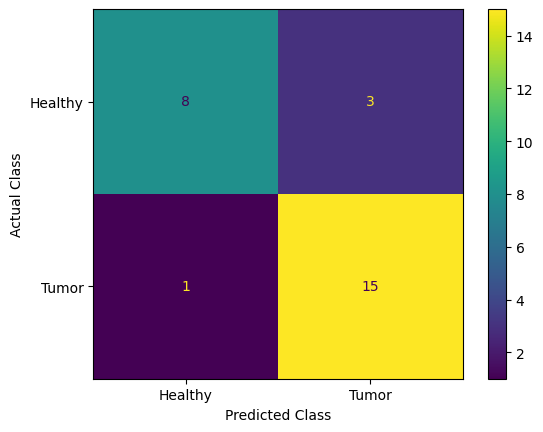

In [68]:
from sklearn import metrics

classes = ("Tumor", "Healthy")
y_pred = []
y_true = []

for inputs, labels in test_loader:
    output = model(inputs)  # Feed Network

    _, predicted = torch.max(output.data, 1)
    y_pred.extend(predicted)  # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)  # Save Truth

# Build confusion matrix
cf_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cf_matrix, display_labels=["Healthy", "Tumor"]
)

cm_display.plot()
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
import cv2


def load_images(folder, size=(128, 128)):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if not os.path.isdir(label_folder):
            continue
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, size)
                images.append(img.flatten())
                labels.append(label)
    return np.array(images), np.array(labels)


X_train, y_train = load_images("data_split/train")
X_test, y_test = load_images("data_split/test")

# Min-Max Scaling
X_train = X_train / 255.0
X_test = X_test / 255.0


le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
print("Accuracy:", metrics.accuracy_score(y_test_enc, y_pred))
print(metrics.classification_report(y_test_enc, y_pred, target_names=le.classes_))

Accuracy: 0.8518518518518519
              precision    recall  f1-score   support

          no       0.89      0.73      0.80        11
         yes       0.83      0.94      0.88        16

    accuracy                           0.85        27
   macro avg       0.86      0.83      0.84        27
weighted avg       0.86      0.85      0.85        27

